In [12]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

In [13]:
times = {"cores":[],"mean":[],"meanerr":[],"throughput_GB_s":[]}
timedir = "hl-d102-20211111-1numanode-16cores/appruntimes"
datasetsize = 157400503680
readpercent = 0.7949011466389114
readsize = 112940757600
for f in os.listdir(timedir):
    array = numpy.genfromtxt(timedir+"/"+f, skip_header=1)
    nodes = f.split("_")[4].replace("cores.csv","")
    time_mean = numpy.mean(array)
    times["cores"].append(int(nodes))
    times["mean"].append(round(time_mean, 2))
    times["meanerr"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_GB_s"].append(readsize/time_mean/pow(10, 9))
    
timesdf = pandas.DataFrame(times)
timesdf = timesdf.sort_values(by="cores").reset_index(drop=True).copy()
timesdf

,cores,mean,meanerr,throughput_GB_s
0,1,162.65,1.67,0.694383
1,2,92.25,1.24,1.224346
2,4,51.03,0.42,2.213281
3,6,36.57,0.34,3.088532
4,8,28.82,0.43,3.919467
5,10,32.86,0.39,3.436715
6,12,28.04,0.19,4.027589
7,14,25.21,0.22,4.480235
8,16,22.89,0.10,4.933922


In [14]:
throughput_1node = timesdf["throughput_GB_s"][0]
timesdf["throughputspeedup"] = timesdf["throughput_GB_s"] / throughput_1node
timesdf

,cores,mean,meanerr,throughput_GB_s,throughputspeedup
0,1,162.65,1.67,0.694383,1.000000
1,2,92.25,1.24,1.224346,1.763215
2,4,51.03,0.42,2.213281,3.187407
3,6,36.57,0.34,3.088532,4.447881
4,8,28.82,0.43,3.919467,5.644533
5,10,32.86,0.39,3.436715,4.949308
6,12,28.04,0.19,4.027589,5.800242
7,14,25.21,0.22,4.480235,6.452111
8,16,22.89,0.10,4.933922,7.105477


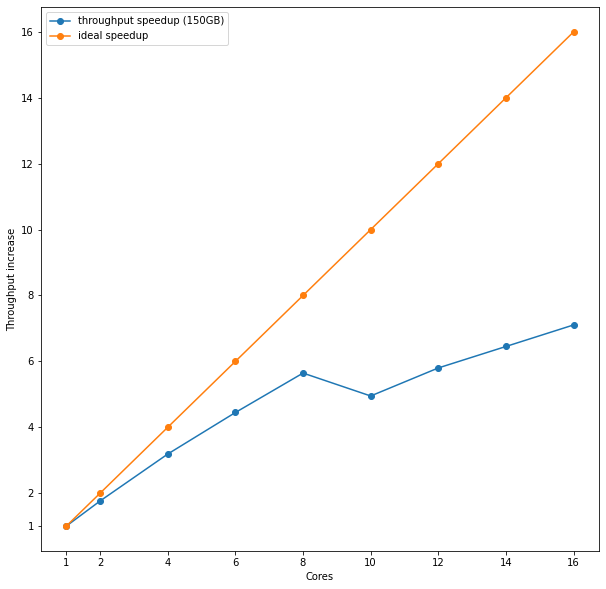

In [15]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["cores"], timesdf["throughputspeedup"], label="throughput speedup (150GB)", marker="o")
pyplot.plot(timesdf["cores"], timesdf["cores"], label="ideal speedup", marker="o")
pyplot.xticks(timesdf["cores"])
pyplot.yticks(timesdf["cores"])
pyplot.xlabel("Cores")
pyplot.ylabel("Throughput increase")
pyplot.legend()

No handles with labels found to put in legend.


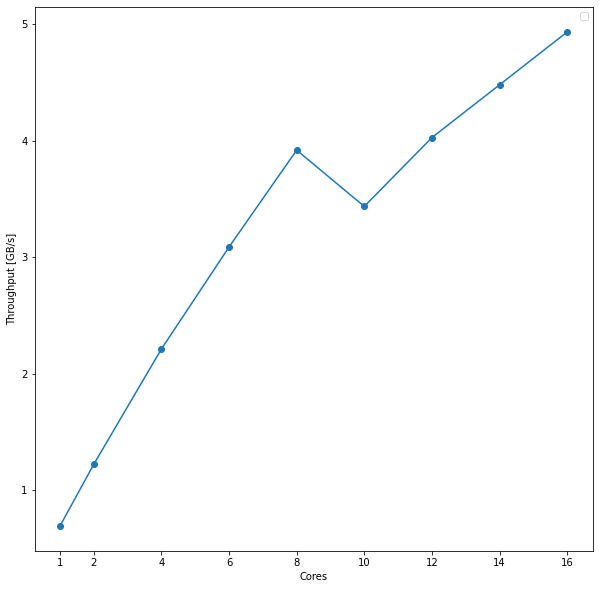

In [16]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["cores"], timesdf["throughput_GB_s"], marker="o")
pyplot.xticks(timesdf["cores"])

pyplot.xlabel("Cores")
pyplot.ylabel("Throughput [GB/s]")
pyplot.legend()

# RNTuple read throughput

In [17]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "hl-d102-20211111-1numanode-16cores"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    cores = timedir.split("_")[2].replace("processes","")
    chunks = cores
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = f.split("_")[2].replace("process","").replace(".txt","")
        df["taskid"] = int(taskid)
        df["cores"] = int(cores)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by=["cores","taskid"]).reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,cores
0,169.351,168930509358,668,112940757600,0,1
1,171.742,171324371080,659,112940757600,0,1
2,161.024,160613378290,703,112940757600,0,1
3,160.539,160121267253,705,112940757600,0,1
4,157.825,157411980811,717,112940757600,0,1
...,...,...,...,...,...,...
652,21.319,20918031658,337,7058797416,15,16
653,22.843,22417775244,314,7058797416,15,16
654,21.335,20904318412,337,7058797416,15,16
655,22.501,22076344748,319,7058797416,15,16


In [18]:
meantaskthroughput = df.groupby(["cores"]).mean()[["taskruntime","taskreadtime","readthroughput","readpayload"]]
meantaskthroughput = meantaskthroughput.reset_index().sort_values("cores").reset_index(drop=True)
meantaskthroughput["taskreadtime_s"] = meantaskthroughput["taskreadtime"] / pow(10, 9)
meantaskthroughput

,cores,taskruntime,taskreadtime,readthroughput,readpayload,taskreadtime_s
0,1,162.497556,1.620820e+11,697.000000,1.129408e+11,162.081978
1,2,90.781278,9.049408e+10,624.388889,5.647038e+10,90.494085
2,4,49.125861,4.888425e+10,578.416667,2.823519e+10,48.884245
3,6,34.879648,3.460627e+10,544.166667,1.882346e+10,34.606266
4,8,26.727111,2.646901e+10,535.347222,1.411759e+10,26.469006
5,10,25.974533,2.563613e+10,454.877778,1.129408e+10,25.636135
6,12,23.663500,2.331739e+10,419.222222,9.411730e+09,23.317388
7,14,22.871524,2.246296e+10,366.238095,8.067197e+09,22.462956
8,16,21.566375,2.114611e+10,334.055556,7.058797e+09,21.146114


Text(0, 0.5, 'Throughput [MB/s]')

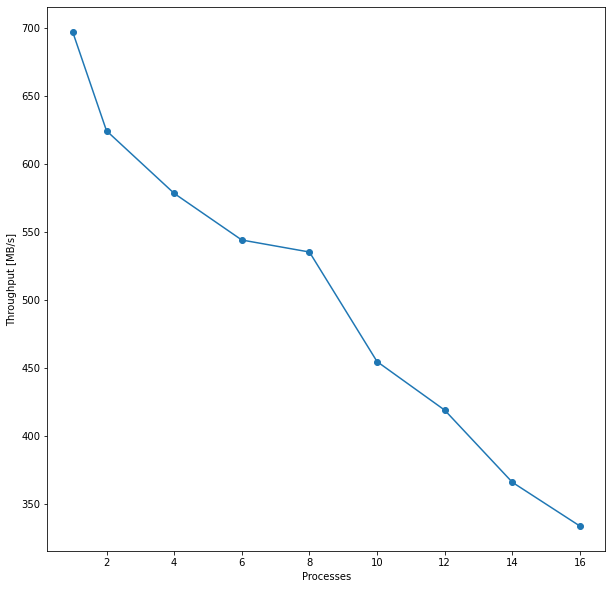

In [19]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["cores"], meantaskthroughput["readthroughput"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [MB/s]")

Text(0, 0.5, 'Time [s]')

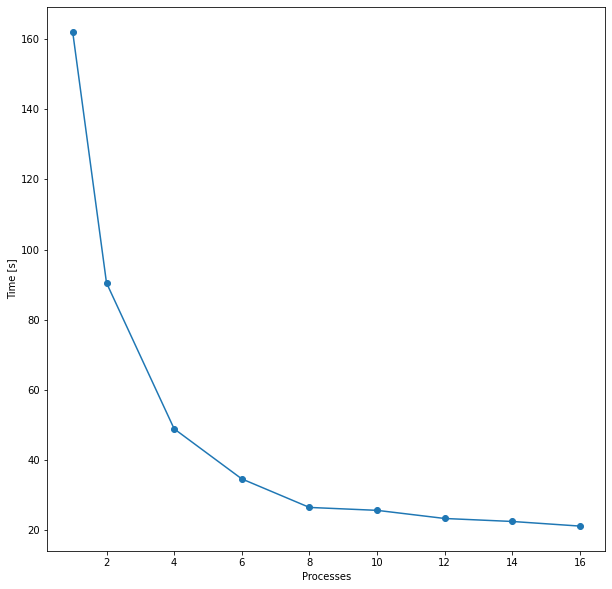

In [20]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["cores"], meantaskthroughput["taskreadtime_s"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Time [s]")

In [21]:
sumthroughput = df.groupby(["cores","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["cores"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / 1024
sumthroughput["readthroughputspeedup"] = sumthroughput["readthroughput"] / sumthroughput["readthroughput"][0]
sumthroughput

,cores,taskid,taskruntime,taskreadtime,readthroughput,readpayload,totalthroughput,readthroughputspeedup
0,1,0,162.497556,1.620820e+11,697.000000,1.129408e+11,0.680664,1.000000
1,2,1,181.562556,1.809882e+11,1248.777778,1.129408e+11,1.219510,1.791647
2,4,6,196.503444,1.955370e+11,2313.666667,1.129408e+11,2.259440,3.319464
3,6,15,209.277889,2.076376e+11,3265.000000,1.129408e+11,3.188477,4.684362
4,8,28,213.816889,2.117520e+11,4282.777778,1.129408e+11,4.182400,6.144588
5,10,45,259.745333,2.563613e+11,4548.777778,1.129408e+11,4.442166,6.526223
6,12,66,283.962000,2.798087e+11,5030.666667,1.129408e+11,4.912760,7.217599
7,14,91,320.201333,3.144814e+11,5127.333333,1.129408e+11,5.007161,7.356289
8,16,120,345.062000,3.383378e+11,5344.888889,1.129408e+11,5.219618,7.668420


Text(0, 0.5, 'Throughput [GB/s]')

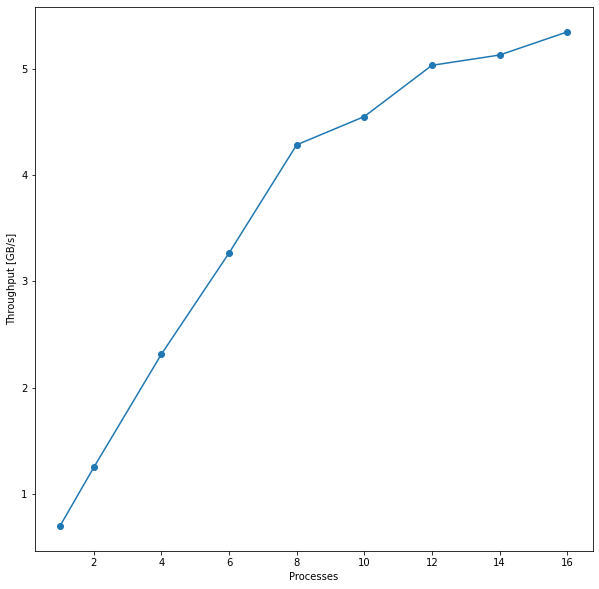

In [22]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["cores"], sumthroughput["readthroughput"]/1000, marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [GB/s]")

Text(0, 0.5, 'Throughput increase')

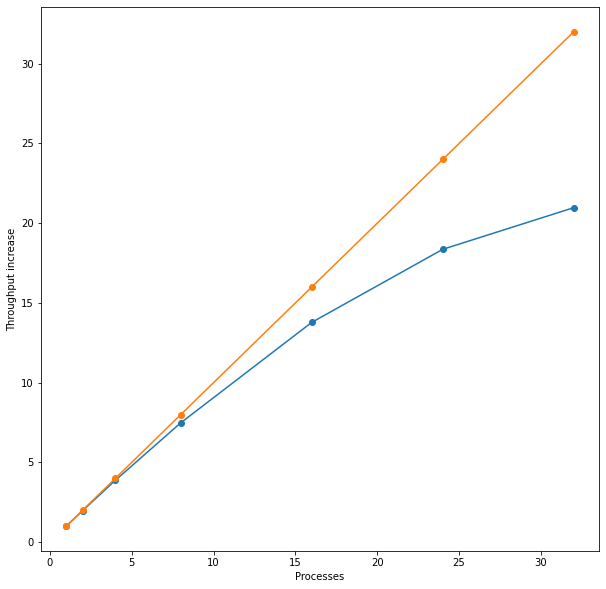

In [76]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["cores"], sumthroughput["readthroughputspeedup"], marker="o")
pyplot.plot(sumthroughput["cores"], sumthroughput["cores"], marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput increase")

# TGraph

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_processingthroughput.png has been created


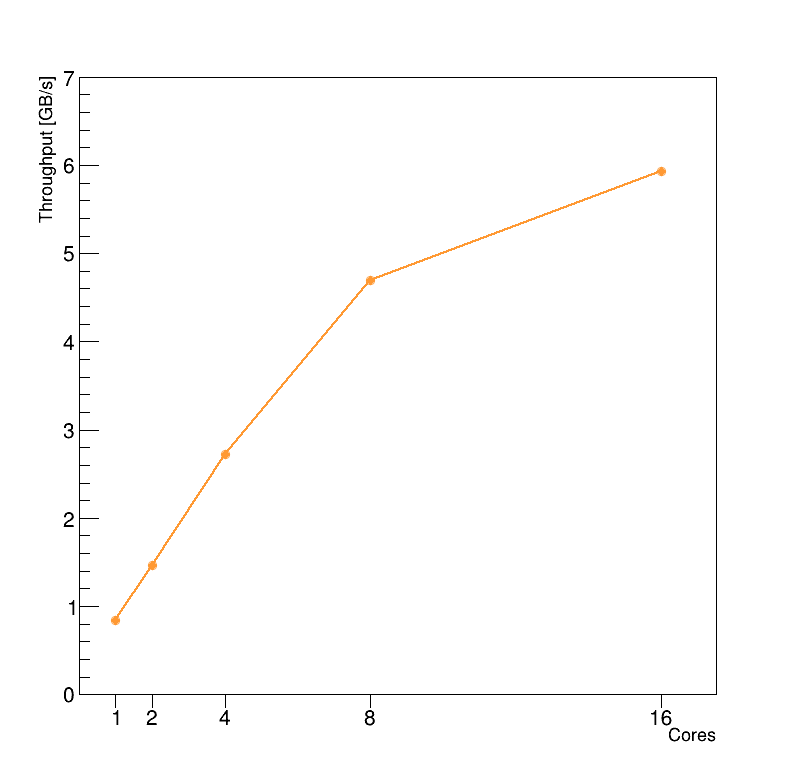

In [151]:
runtimegraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["throughput_GB_s"], dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Cores")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 7)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(5):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_singlenode_processingthroughput.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_processingthroughputspeedup.png has been created


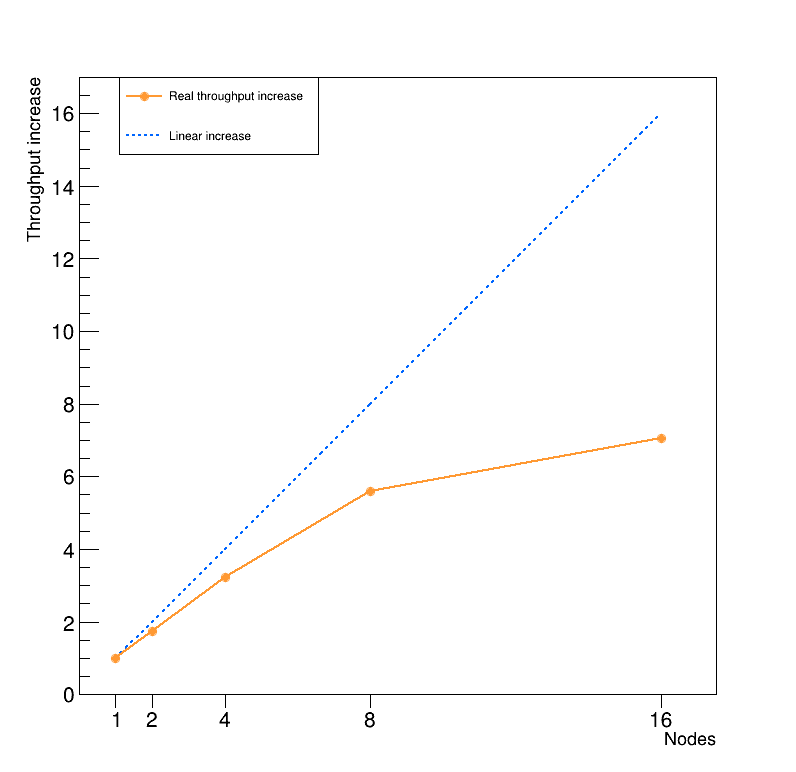

In [149]:
speedupgraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["throughputspeedup"], dtype=float))
idealspeedupgraph = ROOT.TGraph(len(timesdf["cores"]), numpy.array(timesdf["cores"], dtype=float), numpy.array(timesdf["cores"], dtype=float))

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.025)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Throughput increase")

idealspeedupgraph.GetYaxis().SetTitleSize(0.025)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetYaxis().SetRangeUser(0, 17)
idealspeedupgraph.GetYaxis().SetLabelSize(0.03)

idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
idealspeedupgraph.SetMarkerSize(1)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(ROOT.kAzure-3,1)
idealspeedupgraph.SetLineWidth(2)
idealspeedupgraph.Draw("AL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(timesdf["cores"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, -0.9, str(int(x)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)

speedupgraph.SetMarkerStyle(20)
speedupgraph.SetMarkerSize(1)
speedupgraph.SetMarkerColor(ROOT.kOrange+1)


speedupgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
speedupgraph.SetLineWidth(2)

speedupgraph.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.8,0.4,0.9)
legend.AddEntry(speedupgraph, "Real throughput increase")
legend.AddEntry(idealspeedupgraph, "Linear increase", "L")
legend.Draw()

c.Draw()
c.SaveAs("distrdf_lhcb_singlenode_processingthroughputspeedup.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lhcb_singlenode_readthroughput.png has been created


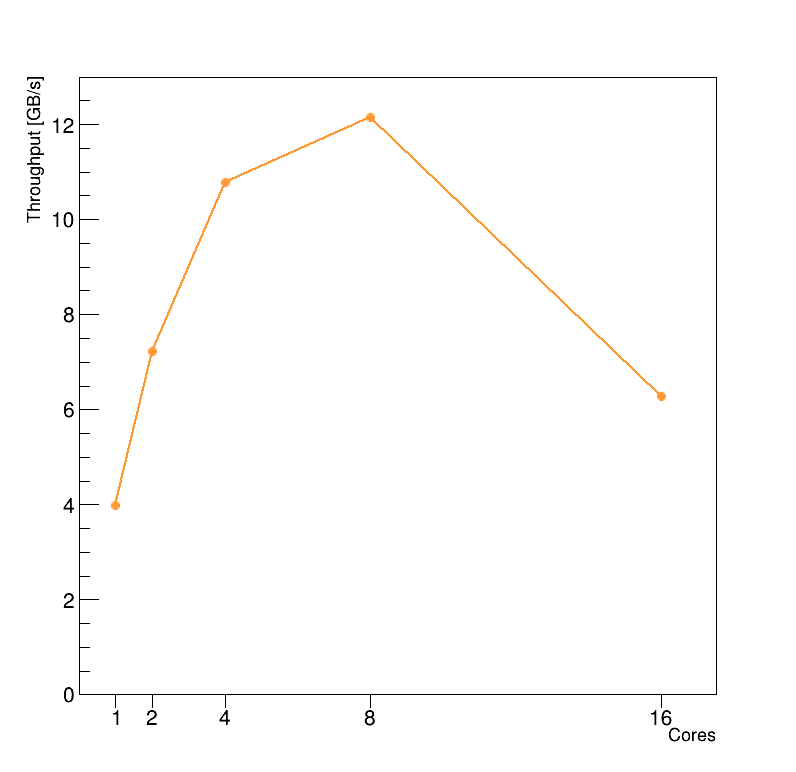

In [150]:
runtimegraph = ROOT.TGraph(len(sumthroughput["cores"]), numpy.array(sumthroughput["cores"], dtype=float), numpy.array(sumthroughput["readthroughput"]/1000, dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Cores")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 13)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(len(sumthroughput["cores"])):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_singlenode_readthroughput.png")